final project for the cet 0610 - data warehouse course

https://github.com/DereoDuran/cet-0610-data-warehouse

- José Duran
- Mirray Teixeira
- André Silva
- Gabriel Sari

In [25]:
import pandas as pd
from IPython.display import Image
from utils import MysqlConnector
from faker import Faker
import datetime
conn = MysqlConnector()
fake = Faker()

## Questão 1

A empresa "Flut Flight" fornece serviços de voos charter sob demanda, usando diferentes tipos de aviões. O gestor de operações pretende analisar dados dos voos charter, como por exemplo custos, horas de voo, despesas com combustível, receitas e despesas. Também pretende realizar diversas análises por piloto, cliente, avião, tipo de aeronave e período de tempo (semana, mês, trimestre, ano).

Os requisitos para o data warehouse são:
- Apresentar as quantidades de horas de voo por diferentes aviões, pilotos e agrupados pelos períodos de ano e mês.
- Apresentar os custos totais dos voos, com visões por aeronaves, horas de trabalho da tripulação agrupados por períodos de semana, mês e ano.
- Comparar as receitas dos voos por tripulação, aeronaves, por diferentes períodos.
- Apresentar quais tipos de aeronaves realizam mais horas de manutenções, verificar custos incluídos. 

#### 1. Desenhar o modelo em estrela ou snowflake para o Data Warehouse

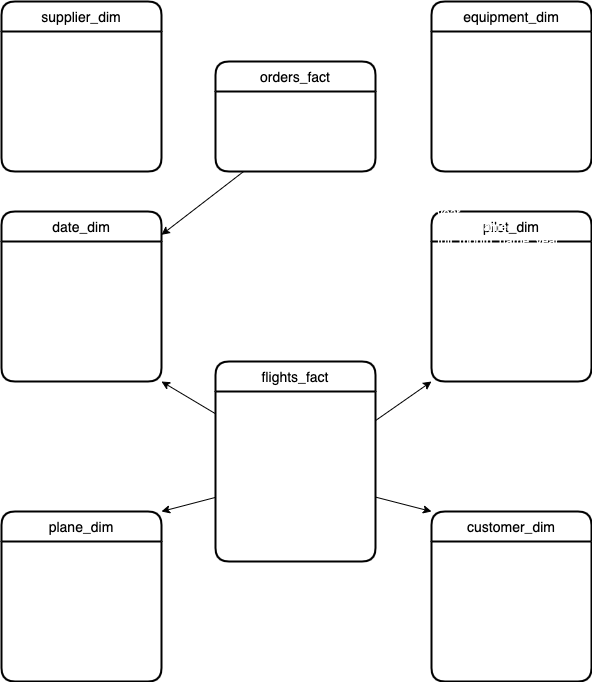

In [26]:
Image(filename='assets/star_schema_flights.png')

Tabela dimensão: datas

In [27]:
conn.execute("USE dw;")
conn.execute("DROP TABLE IF EXISTS date_dim;")
conn.execute("""
CREATE TABLE date_dim (
    date_id INT PRIMARY KEY,
    month INT,
    year INT,
    month_name VARCHAR(50),
    full_month_name_year VARCHAR(100)
);
""")
             
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
date = datetime.date(2021, 1, 1)
for counter in range(1, 37):
    month = date.month
    year = date.year
    month_name = month_names[month - 1]
    full_month_name_year = f"{month_name} {year}"
    conn.execute(f"INSERT INTO date_dim (date_id, month, year, month_name, full_month_name_year) VALUES ({counter}, {month}, {year}, '{month_name}', '{full_month_name_year}');")
    date = date.replace(month=1, year=date.year + 1) if date.month == 12 else date.replace(month=date.month + 1)

pd.DataFrame(conn.fetch("SELECT * FROM date_dim"))

,0,1,2,3,4
0,1,1,2021,Jan,Jan 2021
1,2,2,2021,Feb,Feb 2021
2,3,3,2021,Mar,Mar 2021
3,4,4,2021,Apr,Apr 2021
4,5,5,2021,May,May 2021
5,6,6,2021,Jun,Jun 2021
6,7,7,2021,Jul,Jul 2021
7,8,8,2021,Aug,Aug 2021
8,9,9,2021,Sep,Sep 2021
9,10,10,2021,Oct,Oct 2021


Tabela dimensão: aviões

In [28]:
conn.execute("DROP TABLE IF EXISTS plane_dim;")
conn.execute("""
CREATE TABLE plane_dim (
    plane_id INT PRIMARY KEY,
    plane_type VARCHAR(255),
    capacity INT,
    purchase_date DATE
);
""")
conn.execute("""
INSERT INTO plane_dim (plane_id, plane_type, capacity, purchase_date)
VALUES 
(1, 'Boeing 737', 160, '2018-05-15'),
(2, 'Airbus A320', 180, '2019-03-20'),
(3, 'Cessna 172', 4, '2020-07-11'),
(4, 'Airbus A320', 180, '2016-11-05'),
(5, 'Airbus A380', 550, '2017-09-23'),
(6, 'Boeing 787 Dreamliner', 240, '2018-02-01'),
(7, 'Embraer E190', 96, '2019-08-12'),
(8, 'Embraer E190', 96, '2021-06-19'),
(9, 'Boeing 737', 160, '2017-04-27'),
(10, 'Cessna 172', 4, '2015-12-09'),
(11, 'Airbus A380', 550, '2022-01-05'),
(12, 'Boeing 737', 160, '2014-10-15'),
(13, 'Embraer E190', 96, '2021-07-17'),
(14, 'Boeing 787 Dreamliner', 240, '2019-03-20'),
(15, 'Cessna 172', 4, '2018-08-12'),
(16, 'Boeing 737', 160, '2016-02-19'),
(17, 'Airbus A320', 180, '2015-12-25'),
(18, 'Embraer E190', 96, '2017-05-07'),
(19, 'Boeing 787 Dreamliner', 240, '2020-09-15'),
(20, 'Cessna 172', 4, '2021-11-20');
""")
pd.DataFrame(conn.fetch("SELECT * FROM plane_dim"))

,0,1,2,3
0,1,Boeing 737,160,2018-05-15
1,2,Airbus A320,180,2019-03-20
2,3,Cessna 172,4,2020-07-11
3,4,Airbus A320,180,2016-11-05
4,5,Airbus A380,550,2017-09-23
5,6,Boeing 787 Dreamliner,240,2018-02-01
6,7,Embraer E190,96,2019-08-12
7,8,Embraer E190,96,2021-06-19
8,9,Boeing 737,160,2017-04-27
9,10,Cessna 172,4,2015-12-09


Tabela dimensão: pilotos

In [29]:
conn.execute("DROP TABLE IF EXISTS pilot_dim;")
conn.execute("""
CREATE TABLE pilot_dim (
    pilot_id INT PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    date_of_birth DATE,
    license_number VARCHAR(50)
);
""")

for i in range(30):
        first_name = fake.first_name()
        last_name = fake.last_name()
        dob = fake.date_of_birth(tzinfo=None, minimum_age=25, maximum_age=55) # Assuming pilots are between 25 and 55 years old
        license_number = f"LIC{fake.random_number(digits=5, fix_len=True)}"
        
        conn.execute(f"INSERT INTO pilot_dim (pilot_id, first_name, last_name, date_of_birth, license_number) VALUES ({i+1}, '{first_name}', '{last_name}', '{dob}', '{license_number}');")


pd.DataFrame(conn.fetch("SELECT * FROM pilot_dim"))

,0,1,2,3,4
0,1,Morgan,Gomez,1995-11-13,LIC84062
1,2,Anita,Ortiz,1970-05-23,LIC55997
2,3,Thomas,Ward,1987-10-04,LIC96949
3,4,Erin,Moore,1981-10-30,LIC86543
4,5,Nicole,Chapman,1971-05-05,LIC67866
5,6,Sarah,Bailey,1987-04-26,LIC19716
6,7,Thomas,Miller,1993-12-26,LIC98982
7,8,Sarah,White,1969-07-03,LIC70494
8,9,Ryan,Ward,1992-09-06,LIC67867
9,10,Jennifer,Jennings,1980-08-22,LIC72393


Tabela dimensão: clientes

In [30]:
conn.execute("DROP TABLE IF EXISTS customer_dim;")
conn.execute("""
CREATE TABLE customer_dim (
    customer_id INT PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    email VARCHAR(100),
    phone VARCHAR(15),
    country VARCHAR(50),
    address VARCHAR(200)
);
""")

for i in range(200):
        first_name = fake.first_name().replace("'", '') 
        last_name = fake.last_name().replace("'", '') 
        email = fake.email()
        phone = fake.phone_number()[:15]
        country = fake.country().replace("'", '') [:50]
        address = fake.address().replace('\n', ', ').replace("'", '')[:200]  

        conn.execute(f"INSERT INTO customer_dim (customer_id, first_name, last_name, email, phone, country, address) VALUES ({i+1}, '{first_name}', '{last_name}', '{email}', '{phone}', '{country}', '{address}');")


pd.DataFrame(conn.fetch("SELECT * FROM customer_dim"))

,0,1,2,3,4,5,6
0,1,Reginald,Wise,jasonhuff@example.net,(381)922-2024,Gibraltar,"008 Owens Shoal, East Lance, CO 43837"
1,2,Clayton,Davis,ksantiago@example.com,538.685.9650,French Polynesia,"39454 Mcdaniel Drive, Port Donaldberg, RI 64627"
2,3,Justin,Park,jspencer@example.com,2626263823,United States of America,"140 Serrano Trace Suite 944, Sotoland, DC 98910"
3,4,Melissa,Shea,fjennings@example.com,368-580-1097x61,Malawi,"2549 Suzanne Neck Suite 013, New Patrick, AR 0..."
4,5,Joseph,Evans,rodriguezjoe@example.com,992-121-9573x60,United States Minor Outlying Islands,"52007 Brown Plain, West Matthew, ME 08889"
...,...,...,...,...,...,...,...
195,196,Joseph,Elliott,slowery@example.com,+1-851-155-8123,Niger,"61636 Adrian Point Suite 364, Daughertyfort, I..."
196,197,Steven,Gray,madison40@example.org,602.200.2402x96,Cape Verde,"800 Bowman Manor Apt. 561, Susantown, NJ 12184"
197,198,Jeff,Robinson,saratucker@example.com,037-792-4407x07,Antigua and Barbuda,"51511 Taylor Drives, Kennethside, CT 50098"
198,199,Kiara,Patton,amydunn@example.net,(452)959-8046x4,Gibraltar,"226 Adrian Mission, Angelaburgh, NV 82390"


Tabela dimensão: equipamentos

In [31]:
conn.execute("DROP TABLE IF EXISTS equipment_dim;")
conn.execute("""
CREATE TABLE equipment_dim (
    equipment_id INT,
    equipment_name VARCHAR(50),
    equipment_type VARCHAR(50)
);
""")
conn.execute("""
INSERT INTO equipment_dim (equipment_id, equipment_name, equipment_type)
VALUES
(1, 'Wings', '1'),
(2, 'Engine', '1'),
(3, 'Landing Gear', '1'),
(4, 'Cockpit', '1'),
(5, 'Fuselage', '1')
;
""")

Tabela dimensão: fornecedores

In [32]:
conn.execute("DROP TABLE IF EXISTS supplier_dim;")
conn.execute("""
CREATE TABLE supplier_dim (
    supplier_id INT,
    supplier_name VARCHAR(50),
    supplier_location VARCHAR(50)
    );
""")
conn.execute("""
INSERT INTO supplier_dim (supplier_id, supplier_name, supplier_location)
VALUES
(1, 'WS Inc.', 'Seattle, WA'),
(2, 'Airbus', 'Toulouse, France'),
(3, 'Boeing', 'Chicago, IL'),
(4, 'Embraer', 'São José dos Campos, Brazil'),
(5, 'Cessna', 'Wichita, KS')
;
""")

Tabela fato: pedidos

In [33]:
conn.execute("DROP TABLE IF EXISTS orders_fact;")
conn.execute("""
CREATE TABLE orders_fact (
    date_id INT,
    supplier_id INT,
    equipment_id INT,
    quantity INT,
    price DECIMAL(10,2)
);
""")

for i in range(2000):
    date_id = fake.random_int(min=1, max=37)
    supplier_id = fake.random_int(min=1, max=5)
    equipment_id = fake.random_int(min=1, max=5)
    quantity = fake.random_int(min=1, max=100)
    price = fake.random_int(min=100, max=10000)
    
    conn.execute(f"INSERT INTO orders_fact (date_id, supplier_id, equipment_id, quantity, price) VALUES ({date_id}, {supplier_id}, {equipment_id}, {quantity}, {price});")

Tabela fato: vôos

In [34]:
conn.execute("DROP TABLE IF EXISTS flights_fact;")
conn.execute("""
CREATE TABLE flights_fact (
    flight_id INT PRIMARY KEY,
    date_id INT,
    pilot_id INT,
    customer_id INT,
    plane_id INT,
    hours_of_flight DECIMAL(5,2),
    total_cost DECIMAL(10,2),
    revenue DECIMAL(10,2),
    fuel_expense DECIMAL(10,2),
    maintenance_hours DECIMAL(5,2),
    region VARCHAR(50)
);
""")

for i in range(50000):
        date_id = fake.random_int(min=1, max=37)
        pilot_id = fake.random_int(min=1, max=30)
        customer_id = fake.random_int(min=1, max=200)
        plane_id = fake.random_int(min=1, max=20)
        hours_of_flight = round(fake.random_number(digits=2, fix_len=True) * 0.01 * 24, 2) 
        total_cost = round(fake.random_number(digits=6) * 0.01, 2)
        revenue = round(total_cost + (fake.random_number(digits=3) * 0.01 * total_cost), 2) 
        fuel_expense = round(fake.random_number(digits=5) * 0.01, 2)
        maintenance_hours = round(fake.random_number(digits=2, fix_len=True) * 0.01 * 24, 2)
        region = fake.country().replace("'", '')[:50]
        
        conn.execute(f"INSERT INTO flights_fact (flight_id, date_id, pilot_id, customer_id, plane_id, hours_of_flight, total_cost, revenue, fuel_expense, maintenance_hours, region) VALUES ({i+1}, {date_id}, {pilot_id}, {customer_id}, {plane_id}, {hours_of_flight}, {total_cost}, {revenue}, {fuel_expense}, {maintenance_hours}, '{region}');")

pd.DataFrame(conn.fetch("SELECT * FROM flights_fact"))

,0,1,2,3,4,5,6,7,8,9,10
0,1,34,30,199,4,2.40,9833.11,65095.19,106.96,6.48,Palestinian Territory
1,2,10,7,100,20,11.52,9864.94,89770.95,824.00,21.84,Montserrat
2,3,2,9,41,20,14.64,8170.79,73128.57,555.86,21.36,Central African Republic
3,4,22,19,94,1,15.60,8810.20,65019.28,798.78,23.28,San Marino
4,5,37,12,32,18,23.04,8583.62,10987.03,779.43,5.76,Antarctica (the territory South of 60 deg S)
...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,26,27,163,13,7.20,2227.65,9601.17,126.38,10.08,Cameroon
49996,49997,37,27,20,16,6.00,8902.05,79317.27,520.27,20.88,Faroe Islands
49997,49998,15,17,90,3,2.40,4759.49,10994.42,174.61,2.88,Montserrat
49998,49999,27,17,101,17,8.88,3072.28,11428.88,384.56,13.44,Mexico


#### 2. Quais aeronaves apresentaram mais lucros para empresa, nos últimos 4 anos, agrupados por mês – (Top 5); 

In [35]:
result = conn.fetch("""
SELECT 
    p.*,
    SUM(f.revenue - f.total_cost) AS lucro_total
FROM 
    flights_fact f
JOIN 
    plane_dim p ON f.plane_id = p.plane_id
JOIN 
    date_dim d ON f.date_id = d.date_id
WHERE 
    year > YEAR(CURDATE()) - 4 OR 
    (year = YEAR(CURDATE()) - 4 AND month >= MONTH(CURDATE()))
GROUP BY 
    p.plane_id
LIMIT 5;
""")

pd.DataFrame(result)

,0,1,2,3,4
0,4,Airbus A320,180,2016-11-05,60103509.69
1,20,Cessna 172,4,2021-11-20,64015121.51
2,1,Boeing 737,160,2018-05-15,60980654.58
3,18,Embraer E190,96,2017-05-07,58917633.07
4,17,Airbus A320,180,2015-12-25,61810599.77


#### 3. Quais aeronaves fizeram mais manutenções, nos últimos 5 anos, agrupados por ano e mês – (Top 5); 

In [36]:
result = conn.fetch("""
SELECT 
    d.year,
    d.month,
    p.*,
    SUM(f.maintenance_hours) AS manutencao_total
FROM 
    flights_fact f
JOIN 
    plane_dim p ON f.plane_id = p.plane_id
JOIN 
    date_dim d ON f.date_id = d.date_id
WHERE 
    year > YEAR(CURDATE()) - 5 OR 
    (year = YEAR(CURDATE()) - 5 AND month >= MONTH(CURDATE()))
GROUP BY 
    p.plane_id, d.year, d.month
ORDER BY
    manutencao_total DESC
LIMIT 5;
""")

pd.DataFrame(result)

,0,1,2,3,4,5,6
0,2021,3,16,Boeing 737,160,2016-02-19,1233.60
1,2022,3,9,Boeing 737,160,2017-04-27,1212.72
2,2021,7,10,Cessna 172,4,2015-12-09,1207.92
3,2021,6,14,Boeing 787 Dreamliner,240,2019-03-20,1203.60
4,2023,2,15,Cessna 172,4,2018-08-12,1172.40


#### 4. Quais foram os voos fretados mais solicitados pelos clientes, nos últimos 3 anos, agrupados por mês

In [37]:
result = conn.fetch("""
SELECT 
    p.*,
    SUM(f.revenue - f.total_cost) AS lucro_total
FROM 
    flights_fact f
JOIN 
    plane_dim p ON f.plane_id = p.plane_id
JOIN 
    date_dim d ON f.date_id = d.date_id
WHERE 
    year > YEAR(CURDATE()) - 4 OR 
    (year = YEAR(CURDATE()) - 4 AND month >= MONTH(CURDATE()))
GROUP BY 
    p.plane_id
LIMIT 5;
""")

pd.DataFrame(result)

,0,1,2,3,4
0,4,Airbus A320,180,2016-11-05,60103509.69
1,20,Cessna 172,4,2021-11-20,64015121.51
2,1,Boeing 737,160,2018-05-15,60980654.58
3,18,Embraer E190,96,2017-05-07,58917633.07
4,17,Airbus A320,180,2015-12-25,61810599.77


#### 5. Quais fornecedores apresentaram maiores custos de manutenção para a empresa "Flut Flight", nos últimos 5 anos, agrupados por ano; 

In [38]:
result = conn.fetch("""
SELECT 
    year,
    supplier_name,
    SUM(price) AS custo_total
FROM 
    orders_fact o
JOIN 
    date_dim d ON o.date_id = d.date_id
JOIN 
    supplier_dim s ON o.supplier_id = s.supplier_id
WHERE 
    year > YEAR(CURDATE()) - 5 OR 
    (year = YEAR(CURDATE()) - 5 AND month >= MONTH(CURDATE()))
GROUP BY 
    year, supplier_name
ORDER BY
    year;
""")

pd.DataFrame(result)

,0,1,2
0,2021,Airbus,645437.00
1,2021,Boeing,655036.00
2,2021,Cessna,610465.00
3,2021,Embraer,670872.00
4,2021,WS Inc.,594012.00
5,2022,Airbus,633677.00
6,2022,Boeing,621152.00
7,2022,Cessna,540432.00
8,2022,Embraer,798015.00
9,2022,WS Inc.,688029.00


#### 6. Quais as peças foram as mais solicitadas para os fornecedores, nos últimos 3 anos, agrupados por ano;

In [39]:
result = conn.fetch("""
SELECT 
    year,
    equipment_name,
    SUM(price) AS custo_total
FROM 
    orders_fact o
JOIN 
    date_dim d ON o.date_id = d.date_id
JOIN 
    equipment_dim e ON o.equipment_id = e.equipment_id
WHERE 
    year > YEAR(CURDATE()) - 3 OR 
    (year = YEAR(CURDATE()) - 3 AND month >= MONTH(CURDATE()))
GROUP BY 
    year, equipment_name
ORDER BY
    year;
""")

pd.DataFrame(result)

,0,1,2
0,2021,Cockpit,620591.00
1,2021,Engine,668857.00
2,2021,Fuselage,664511.00
3,2021,Landing Gear,669667.00
4,2021,Wings,552196.00
5,2022,Cockpit,684996.00
6,2022,Engine,618216.00
7,2022,Fuselage,681563.00
8,2022,Landing Gear,586735.00
9,2022,Wings,709795.00


#### 7. Quais foram os maiores tempos de voos da companhia (Top 10), nos últimos 5 anos, agrupados por região.

In [40]:
result = conn.fetch("""
SELECT 
    f.region,
    MAX(hours_of_flight) AS max_horas_voo
FROM 
    flights_fact f
GROUP BY 1
ORDER BY 2 DESC;
""")

pd.DataFrame(result)

,0,1
0,Palestinian Territory,23.76
1,Montserrat,23.76
2,Central African Republic,23.76
3,San Marino,23.76
4,Antarctica (the territory South of 60 deg S),23.76
...,...,...
238,Dominican Republic,23.52
239,Gibraltar,23.28
240,Guadeloupe,23.28
241,Bahrain,23.28


## Questão 2

A empresa administradora de espetáculos "Moments" necessita de um "data warehouse" que seja composto por quatro dimensões: data, público, localização e jogos, sendo os fatos mensuráveis quantidade e bilheteria. Onde a bilheteria é o preço que um espectador paga para assistir a um jogo numa determinada data numa certa localização.
Os espectadores podem ser estudantes, adultos ou idosos (maiores 65 anos), tendo cada uma destas categorias a sua respectiva tarifa.

#### a) Desenhar o modelo estrela ou snowflake para o Data Warehouse acima;

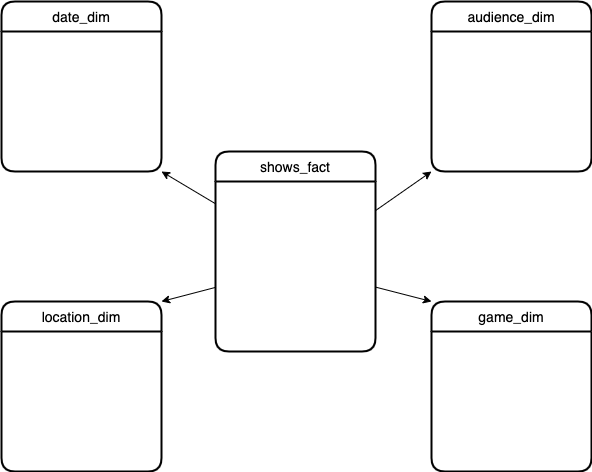

In [41]:
Image(filename='assets/star_schema_shows.png')

#### b) Quais foram os preços totais pagos nos jogos, pelos estudantes desde o ano 2022 em todos os estádios;

```sql
SELECT
    g.game_description AS "Jogo",
    SUM(s.tickets) AS "Preço Total"
FROM 
    shows_fact s
JOIN 
    date_dim d ON s.date_id = d.date_id
JOIN 
    audience_dim a ON s.audience_id = a.audience_id
JOIN 
    game_dim g ON s.game_id = g.game_id
WHERE 
    a.audience_description = 'Estudante'
    AND d.year >= 2022
GROUP BY 
    g.game_description
ORDER BY 
    "Preço Total" DESC;

```

#### c) Quais regiões onde os jogos possuem maior renda de bilheteria, nos últimos 5 anos, agrupados por mês;

```sql
SELECT
    l.location_region AS "Região",
    d.month_name AS "Mês",
    SUM(s.tickets) AS "Renda de Bilheteria"
FROM 
    shows_fact s
JOIN 
    date_dim d ON s.date_id = d.date_id
JOIN 
    location_dim l ON s.location_id = l.location_id
WHERE 
    d.year BETWEEN EXTRACT(YEAR FROM CURRENT_DATE) - 5 AND EXTRACT(YEAR FROM CURRENT_DATE)
GROUP BY 
    l.location_region,
    d.month_name
ORDER BY 
    "Renda de Bilheteria" DESC,
    l.location_region,
    d.month_name;
```

#### d) Quais jogos tiveram maiores públicos de idosos (maiores de 65 anos), nos últimos 2 anos;

```sql
SELECT
    g.game_description AS "Jogo",
    SUM(s.quantity) AS "Número de Idosos"
FROM 
    shows_fact s
JOIN 
    date_dim d ON s.date_id = d.date_id
JOIN 
    audience_dim a ON s.audience_id = a.audience_id
JOIN 
    game_dim g ON s.game_id = g.game_id
WHERE 
    a.audience_description = 'Idoso (65+)'
    AND d.year BETWEEN EXTRACT(YEAR FROM CURRENT_DATE) - 2 AND EXTRACT(YEAR FROM CURRENT_DATE)
GROUP BY 
    g.game_description
ORDER BY 
    "Número de Idosos" DESC;
```

#### e) Quais jogos tiveram os maiores públicos pagantes de não idosos, no último ano;

```sql
SELECT
    g.game_description AS "Jogo",
    SUM(s.quantity) AS "Número de Não Idosos"
FROM 
    shows_fact s
JOIN 
    date_dim d ON s.date_id = d.date_id
JOIN 
    audience_dim a ON s.audience_id = a.audience_id
JOIN 
    game_dim g ON s.game_id = g.game_id
WHERE 
    a.audience_description <> 'Idoso (65+)'
    AND d.year = EXTRACT(YEAR FROM CURRENT_DATE) - 1
GROUP BY 
    g.game_description
ORDER BY 
    "Número de Não Idosos" DESC;
```

#### f) Quais jogos tiveram a pior bilheteria desde o ano de 2019 em todos os estádios, agrupados por ano e mês;

```sql
SELECT
    d.year AS "Ano",
    d.month_name AS "Mês",
    g.game_description AS "Jogo",
    SUM(s.tickets) AS "Bilheteria"
FROM 
    shows_fact s
JOIN 
    date_dim d ON s.date_id = d.date_id
JOIN 
    game_dim g ON s.game_id = g.game_id
WHERE 
    d.year >= 2019
GROUP BY 
    d.year,
    d.month_name,
    g.game_description
ORDER BY 
    d.year,
    d.month_name,
    "Bilheteria" ASC;
```

#### g) Quais são as quantidades e valores das bilheterias para o público de estudantes nos anos de 2023 a 2018.

```sql
SELECT
    d.year AS "Ano",
    SUM(s.quantity) AS "Quantidade de Ingressos",
    SUM(s.tickets) AS "Bilheteria"
FROM 
    shows_fact s
JOIN 
    date_dim d ON s.date_id = d.date_id
JOIN 
    audience_dim a ON s.audience_id = a.audience_id
WHERE 
    a.audience_description = 'Estudante'
    AND d.year BETWEEN 2018 AND 2023
GROUP BY 
    d.year
ORDER BY 
    d.year DESC;
```